# Trial Run PPO Implementation with Graph Representation for Testing
Since I don't currently have the right system requirements to run IsaacSim on my laptop, and I can't fully figure out how Ubuntu works, I am going to use a graph representation of agent learning to facilitate the reinforcement learning implementation of proximal policy optimization. The basis of the system should work even when I eventually move it to IsaacSim when I figure out how to get that working.

### Steps Outlined
Set up RL playground
    design a custom environment where the agent navigates a graph from start to goal
    each node is a state; edges are actions
    rewards are based on movement, reaching the goal, or hitting obstacles

Build your own graph data structure
    use an adjacency list or matrix
        nodes = physical locations/positions
        edges = valid movements (e.g., forward, turn, jump over something)
        add weights or tags for terrain difficulty or obstacles
    create a graph class with methods like addNode, addEdge, getNeighbors
    add properties like obstacle nodes, goal nodes, or penalty weights

Wrap it like a gym environment
    reset()--> to reset the robot to start node
    step(action)--> to move to a neighbor node and return new state, reward, done
    render()--> optional! just print or draw a graph using matplotlib if you want visuals
    observationSpace and actionSpace --> keep it simple (e.g., discrete node indices)
    use gym.Env as your base class, or just fake the API if you don't wanna use the whole library

Define your PPO agent logic
    break this into pieces
        policy network: takes a state--> outputs action probabilities
        value network: predicts state value
        buffer: stores (state, action, reward, nextState, done)
        loss functions:
            policy loss (using PPO clipped objective)
            value function loss
            entropy bonus (to encourage exploration)
    use pytorch for training the agent, unless you're using a library like stable baselines3, which handles PPO for you

Train the agent
    the loop looks like this:
        reset env
        for each step:
            choose action from policy
            move in your graph
            store data in buffer
        at end of episode:
            use buffer to update policy with PPO rules
    train across multiple episodes until agent consistently reaches the goal efficiently

Analyze and Improve
    try different graph layouts
    add complexity like traps, rewards, dead-ends
    use curriculum learning (start easy --> harder graphs)
    tune hyperparameters like gamma, learning rate, epsilon clip

## Set Up Graph Representation

In [62]:
class Edge:
    def __init__(self, n1, n2, weight):
        self.e = (n1, n2)
        self.weight = weight

class Graph:
    
    nodes = set() # set of all state identifiers (e.g., "A", "B", or numbers)
    edges = {} # dictionary mapping from node -> list of neighbor nodes
    obstacles = set()
    start = None
    goal = None
    height = None
    width = None

    # adds node to graph
    def addNode(self, node, isObstacle, isStart, isGoal):
        self.nodes.add(node)
        if isObstacle == True:
            self.obstacles.add(node)

        if isStart == True:
            self.start = node
            
        if isGoal == True:
            self.goal = node

    # adds edge to graph
    def addEdge(self, n1, n2, weight):

        # checking if node already in graph and adding if not
        if n1 not in Graph.nodes:
            self.nodes.add(n1)
        if n2 not in Graph.nodes:
            self.nodes.add(n2)

        # initializing edge and adding into edge dictionary/graph
        edge = Edge(n1, n2, weight)
        if self.edges.get((n1, n2)) == None:
            self.edges[(n1, n2)] = edge

    # method for building graph from grid read from input
    def buildFromGrid(self, grid):
        self.height = len(grid)
        self.width = len(grid[0])
        
        for row in range(len(grid)):
            for col in range(len(grid[row])):
                node = (row, col)

                # checking for type of node and adding correct type into graph
                if grid[row][col] == 'S':
                    self.addNode(node, False, True, False)
                elif grid[row][col] == 'G':
                    self.addNode(node, False, False, True)
                elif grid[row][col] == '#':
                    self.addNode(node, True, False, False)
                else:
                    self.addNode(node, False, False, False)
                
                # adding viable edges for each current node we're adding to graph
                if col+1 >= len(grid[row]):
                    self.addEdge(node, (row, col+1), 1)
                if col-1 < 0:
                    self.addEdge(node, (row, col-1), 1)
                if row+1 >= len(grid):
                    self.addEdge(node, (row+1, col), 1)
                if row-1 < 0:
                    self.addEdge(node, (row-1, col), 1)


    # returns if given node is an obstacle
    def isObstacle(self, node):
        if node in self.obstacles:
            return True
        else:
            return False
        
    # return weight of given edge
    def getEdgeCost(self, n1, n2):
        return self.edges[(n1, n2)].weight
    
    # method returns neighbors of given node
    def getNeighbors(self, node):
        neighbors = []
        for (n1, n2) in self.edges:
            if n1 == node:
                neighbors.append(n2)

        return neighbors
    
    # validating that everything has been correctly added to graph
    def validateGraph(self):
        for (n1, n2) in self.edges:
            if n1 not in self.nodes:
                print("Warning: Node not added to graph")
            if n2 not in self.nodes:
                print("Warning: Node not added to graph")
        
        for node in self.obstacles:
            if node not in self.nodes:
                print("Warning: Node not added to graph")

    # displaying graph to ensure that everything is working correctly
    def displayGrid(self):
        for r in range(self.height):
            for c in range(self.width):
                if (r, c) == self.start:
                    print('S', end='')
                elif (r, c) == self.goal:
                    print('G', end='')
                elif (r, c) in self.obstacles:
                    print('#', end='')
                elif (r, c) in self.nodes:
                    print('.', end='')
                else:
                    print(" ", end='')
            print()

    


goal now is to create a small graph that:
    has a clear start and goal
    includes obstacles
    has some interesting paths (shortcuts, dead ends, etc.)
    is small enough to debug easily

step 1: decide the layout
    each cell is a node (x, y)
    (0,0) -- (0,1) -- (0,2)
      |        |       |
    (1,0) -- (1,1) -- (1,2)
      |        |       |
    (2,0) -- (2,1) -- (2,2)

step 2: choose obstacles
    block off a few tiles (like a tiny maze)
    obstacles = {(1,1), (2,0)}

step 3: connect nodes with edges
    manually or programmatically create edges between adjacent cells (up, down, left, right) skipping any nodes that are obstacles
    set weights to 1 for simplicity

step 4: assign start and goal
    start = (0, 0)
    goal = (2, 2)

step 5: use this to test


In [63]:
myGraph = Graph()
grid = []
with open("simple_graph.txt") as file:
    for line in file:
        grid.append(line.strip())

#
myGraph.buildFromGrid(grid)
myGraph.validateGraph()
myGraph.displayGrid()


S..
.#.
#.G


## Building RL-Compatible Playground Interface

Episode done in 63 steps, total reward got: -40.3000
Episode done in 10 steps, total reward got: -5.3000
Episode done in 28 steps, total reward got: -12.5000
Episode done in 42 steps, total reward got: -24.7000
Episode done in 205 steps, total reward got: -124.7000


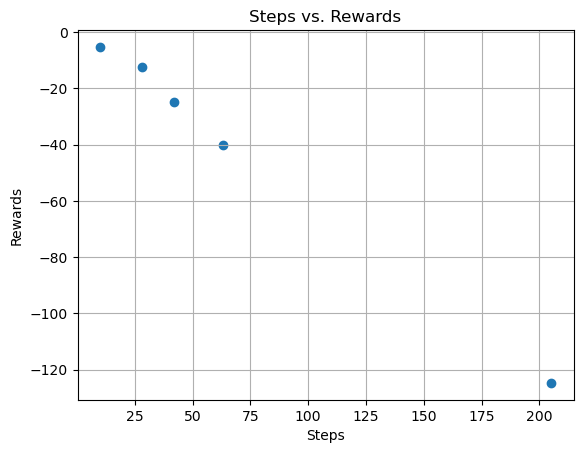

In [ ]:
import random

# goal is to build a custom RL environment (gridworld style)
# will be the foundation to plug into PPO later
# define environment elements
# make a class like graphenv that handles state, actions, transitions, rewards, and done status
class GraphEnv:
    myGraph = Graph()
    start = None
    goal = None
    agentPos = None
    score = 0
    done = False

    def __init__(self, graph):
        self.myGraph = graph
        self.start = graph.start
        self.goal = graph.goal
        self.agentPos = self.start

    # returning the current environment's observation to the agent
    # in this case it's the current state of myGraph
    def getObservation(self):
        return self.myGraph

    # allows the agent to query the set of actions it can execute
    # normally the set of actions does not change over time,
    # but some actions can become impossible in different states
    # in this case, the agent can take four actions (up, down, left, right)
    # which are encoded respectively with the integers, 0, 1, 2, 3
    def getActions(self):
        return [0, 1, 2, 3]

    # signals the end of the episode to the agent
    # in this case, it's when the agent reaches the goal
    def isDone(self):
        return self.agentPos == self.goal

    # central piece in the environment's functionality
    # handles an agent's action and returns the reward for this action
    def action(self, action: int):
        if self.isDone():
            raise Exception("Game is over")
        
        # have agent take steps in environment and returning reward through score
        agentRow = self.agentPos[0]
        agentCol = self.agentPos[1]
        if action == 0:
            if agentRow-1 < 0:
                reward = -1
            elif (agentRow-1, agentCol) in myGraph.obstacles:
                reward = -1
            else:
                nextPos = (agentRow-1, agentCol)
               
                if nextPos == self.goal:
                    reward = 1
                else:
                    reward = -0.1

                self.agentPos = nextPos

        elif action == 1:
            if agentRow+1 >= myGraph.height:
                reward = -1
            elif (agentRow+1, agentCol) in myGraph.obstacles:
                reward = -1
            else:
                nextPos = (agentRow+1, agentCol)

                if nextPos == self.goal:
                    reward = 1
                    
                else:
                    reward = -0.1

                self.agentPos = nextPos

        elif action == 2:
            if agentCol-1 < 0:
                reward = -1
            elif (agentRow, agentCol-1) in myGraph.obstacles:
                reward = -1
            else:
                nextPos = (agentRow, agentCol-1)

                if nextPos == self.goal:
                    reward = 1
                    
                else:
                    reward = -0.1

                self.agentPos = nextPos

        elif action == 3:
            if agentCol+1 >= myGraph.width:
                reward = -1
            elif (agentRow, agentCol+1) in myGraph.obstacles:
                reward = -1
            else:
                nextPos = (agentRow, agentCol+1)

                if nextPos == self.goal:
                    reward = 1
                    
                else:
                    reward = -0.1

                self.agentPos = nextPos

        else:
            reward = -1

        return reward
    
        
    # set agent back to start
    # return the initial state (like the position)
    def reset(self):
        self.agentPos = self.start
        return self
    


class Agent:

    # initialize the counter that will keep the total reward accumulated by the agent during the episode
    def __init__(self):
        self.totalReward = 0.0

    # accepts the environment instance as an argument
    # allows the agent to observe the environment, make a decision about the action to take
    # based on the observations, submit the action to the environment, and get the reward for the current step
    # ignoring the observation for now
    def step(self, env: GraphEnv):
        currentObs = env.getObservation()
        actions = env.getActions()
        reward = env.action(random.choice(actions))

        self.totalReward += reward


# testing flow
import matplotlib.pyplot as plt

allRewards = []
allSteps = []

for i in range(5):

    env = GraphEnv(myGraph)
    agent = Agent()
    totalSteps = 0

    while not env.isDone():
        agent.step(env)
        totalSteps += 1

    allRewards.append(agent.totalReward)
    allSteps.append(totalSteps)

    print(f'Episode done in {totalSteps} steps, total reward got: {agent.totalReward:.4f}')


# visualize correlation between steps and rewards
plt.scatter(allSteps, allRewards)
plt.title("Steps vs. Rewards")
plt.xlabel("Steps")
plt.ylabel("Rewards")
plt.grid(True)
plt.show()

# finding that less steps equals more rewards, which is what we want to train the agent later
# reward system is good for now, but remember the agent is currently behaving randomly

## Designing and Defining PPO Agent Logic
Going to now design and define the logic for a PPO agent that can take observations from environment, decide what actions to take, learn from the rewards it receives, and improve over time

NEED TO DO THIS